In [1]:
from jqdata import *
import pandas as pd
import numpy as np
import pickle
from tqdm import *
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from prettytable import *
# 设置字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
#mpl.rcParams['font.family']='serif'
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

# 图表主题
plt.style.use('seaborn')

In [2]:
# 获取数据
price_df = get_price(
    '000300.XSHG',
    '2005-04-08',
    '2019-12-31',
    fields=['close', 'pre_close'],
    panel=False)
    
# 计算每日收益
ret = price_df['close'] / price_df['pre_close'] - 1
ret = ret.dropna()

In [3]:
# N阶原点矩计算
def cal_moment(arr: np.array, Order: int):
    return np.mean(arr**Order)

In [4]:
# 计算N阶矩
temp = {}
for n in range(2, 8):
    temp['moment_' + str(n)] = ret.rolling(20).apply(
        cal_moment, kwargs={'Order': n}, raw=False)

# 加入收盘价
temp['close'] = price_df['close']
temp_df = pd.DataFrame(temp)

In [6]:
# 可视化
def plot_twin(df: pd.DataFrame, numRows: int, numCols: int):

    s = numRows * 100 + numCols * 10 + 1
    fig = plt.figure(figsize=(18, 10))
    for i, col_name in enumerate(
        [x for x in df.columns.tolist() if x != "close"]):

        ax1 = fig.add_subplot(s + i)
        df[col_name].plot(ax=ax1, alpha=0.5, label=col_name, color='red')

        plt.xlabel('year')
        ax1.set_ylabel('moment')  # 设置左边纵坐标标签
        plt.legend(loc=2)  # 设置图例在左上方

        ax2 = ax1.twinx()
        df['close'].plot(ax=ax2, grid=True, label='close', alpha=0.4)
        ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
        ax2.set_ylabel('price')  # 设置右边纵坐标标签
        plt.legend(loc=1)  # 设置图例在右上方
        plt.show

我们观察沪深 300 指数的高阶矩对于指数是否存在有领先效应，即， 是否可以通过观察高阶矩的变动来判断市场趋势。如果在A股市场中，如同我们前面分析的一样，在下行的市场趋势中伴随着有高阶矩的上升，并且高阶矩的升高是先于资产价格下跌的，那么我们就可以通过高阶矩来制定择时策略，把握市场趋势。

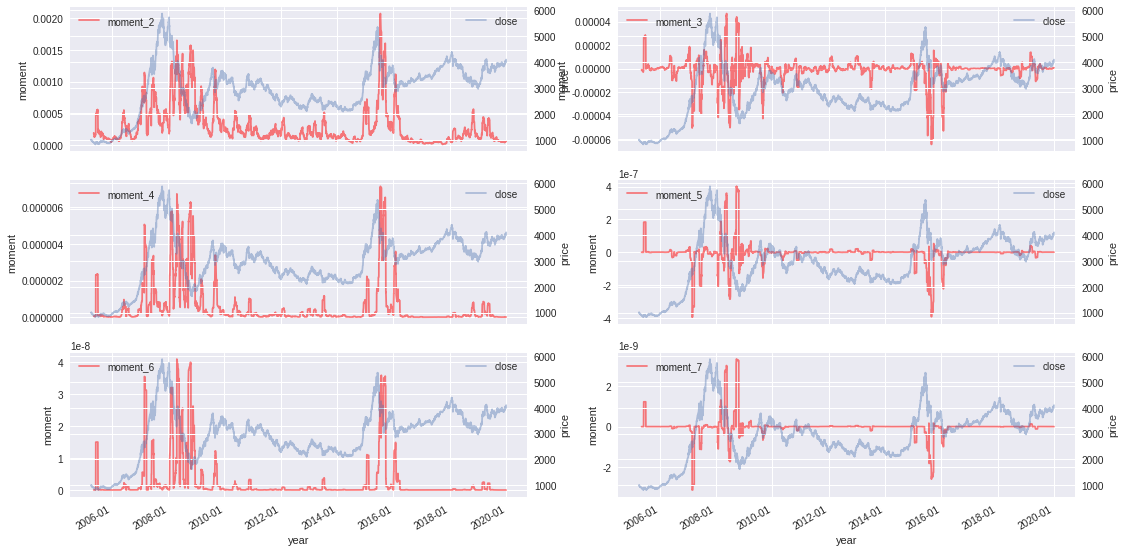

In [6]:
# 查看
plot_twin(temp_df,3,2)

实际市场并不稳定，二阶矩并不恒定。如果我们用采用正态分布的假设，仅仅用趋势项与波动项去刻画资产价格时间序列的变化，就会忽略掉许多重要的信息，无法得到完整的有意义的结 论。注意到在 2008 年的熊市中，二阶矩明显异于平时，陡然升高。在之后的市场中 也是屡有震荡，并不平稳。所以如果我们依据传统资产定价理论来根据期望和方差来进行资产配臵对冲，就会出现明显的漏洞，承担不必要风险与损失。

观察日收益率的 3 至 7 阶矩与沪深 300 指数之间的关系，我们可以发现，他们 具有一个共同的特点，那就是在 2008 年的熊市前异常变化。在这段时间内高阶矩的 量级飞速增大，达到了平时的数倍甚至成百上千倍。这与我们前面通过分析得出的 资产价格符合非线性生灭过程的结论相符。在非线性生灭过程中，不能像传统资产 定价理论中的随机游走模型一样将高阶矩截断忽略，在这种情况下，高阶矩会有明 显的发散效应。所以在资产配臵中，进行风险对冲的时候我们也应该考虑到高阶矩 的存在。特别是在危机中，以往的经验告诉我们，危机时金融资产的相关系数会异 常增大，平时可能关联性不高或者可以很好的进行风险分散的不同资产在此时有可 能会变得关系紧密，同时出现大幅下跌。通过传统的资产定价理论配臵资产会无法达到降低风险的作用。

可以看出，在一个震荡的，并且不存在明显长期趋势的市场中，高阶矩对于市场走势仍然具有一定的判断作用。以 5 阶矩为例，在几次短时间的下降趋势中，5 阶矩都表现出了发散效应，量级大幅提升，而且先于沪深 300 指数变化。而在市场呈平稳上升的趋势中，5 阶矩并没有明显变化，稳定在 0 附近。

这一现象启发我们，可以通过高阶矩来建模择时策略，判断市场趋势。

# 五阶矩简单择时

In [7]:
def cal_ema(arr,alpha):
    series = pd.Series(arr)
    return series.ewm(alpha=alpha,adjust=False).mean().iloc[-1]

In [24]:
# 选取5阶作为信号
ema_window = 90
alpha = ema_window + 1
#singal_series = temp_df['moment_5'].ewm(alpha=2/alpha,adjust=False).mean()
singal_series = temp_df['moment_5'].rolling(ema_window).apply(cal_ema,kwargs={'alpha':2/alpha},raw=False)    
# 获取昨日信号
per_singal = singal_series.shift(1)
# 当然信号大于上日信号
cond = singal_series > per_singal

# 获取持仓

def get_position(ret:pd.Series,cond:pd.Series)->pd.DataFrame:
    
    df = pd.concat([ret,cond],axis=1) # 收益率与信号合并
    df.columns = ['ret','cond']
    
    position = [] # 储存开仓信号，1为持仓，0为空仓
    for idx,row in df.iterrows():
        
        if position:
            
            # 当然出现开仓信号，上一日未持仓
            if row['cond'] and position[-1] == 0:
                
                position.append(1)
                
            # 当然有开仓信号，上日有持仓，大于止损线
            elif row['cond'] and position[-1] == 1 and row['ret']>=-0.1:
                
                position.append(1)
                
            else:
                
                position.append(0)
                
        else:
            
            if row['cond']:
                
                position.append(1)
                
            else:
                
                position.append(0)
    
    df['position'] = position
    
    return df

# 获取
algorithm_return = get_position(ret, cond)

algorithm_return = algorithm_return['ret'].shift(
    -1) * algorithm_return['position']

cum = (1 + algorithm_return).cumprod()
benchmark = (1 + ret).cumprod()

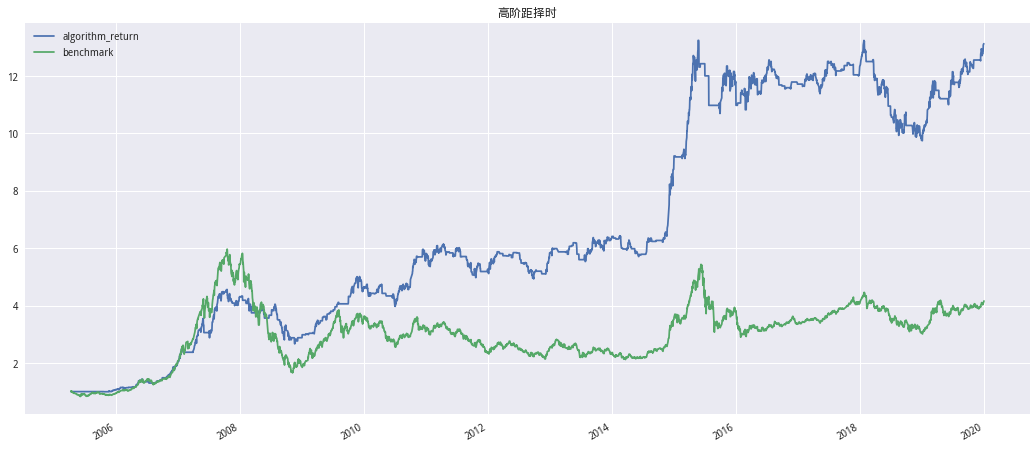

In [25]:
plt.rcParams['font.family']='serif'
# 高阶矩净值
pd.DataFrame({'algorithm_return':cum,'benchmark':benchmark}).plot(title='高阶距择时',figsize=(18,8))

# 五阶矩结合EMA择时

1. 计算每天日收益率的五阶矩，计算公式下式所示，计算数据长度为 20。
$$v_k=\frac{\sum^n_{i=1}x^k_i}{N}$$
2. 在 T 日收盘后，计算出 T 日（含）之前的五阶矩。 
3. 对五阶矩进行指数移动平均处理，具体计算公式如下：
$$EMA=\sum^{120}_{i=1}\alpha*(1-\alpha)^{i-1}*momentt_{T-i+1}$$
参数𝛼取值范围为从 0.05 至 0.5，间隔 0.05，𝑚𝑜𝑚𝑒𝑛𝑡𝑡代表 𝑡日的高阶矩，这样
我们就得到了不同参数下的 T日（含）之前的平滑五阶矩序列。 
4. 滚动窗口样本外推。每隔 90 个交易日，利用 T 日之前 90 个交易日的窗口期数据进行参数确定，需要确定的参数为指数移动平均系数𝛼。通过窗口期数据对不同 𝛼的指数移动平均得到的结果进行测试，按照切线法（详见短线择时策略研究之三《低 延迟趋势线与交易性择时》）确定 T日使得窗口期累积收益最大的指数移动平均参数 $\alpha_{max}$（该值每次可能会发生变化），得到的参数$\alpha_{max}$有效期为90天，直至下一次参 数确定前。 
5. 按照切线法，如果 T 日五阶矩的 EMA$\alpha_{max}$大于 T-1 日的 EMA($\alpha_{max}$)，那么T+1 日的信号为+1，T+1 日看多，建仓价为 T 日收盘价；否则信号为-1，T+1 日看空。 
6. 计算过程设臵 10%止损线，如果单次择时亏损超过 10%即保持空仓位，直至择时信号变化。

In [16]:
# pandas+1次循环
## 五阶矩计算窗口cal_momentt_window = 20
## 外推窗口rolling_window = 90
# 沪深300的起始日2005-04-08

cal_momentt_window = 20
rolling_window = 90

end_date = '2019-12-31'  # 回测截止日

# 获取数据
price_data = get_price(
    '000300.XSHG', start_date='2005-04-08', end_date=end_date, fields='close')

# 计算收益
ret_df = price_data.pct_change()
ret_df.rename(columns={'close': 'ret'}, inplace=True)

# 计算5阶矩
momentt = ret_df['ret'].rolling(cal_momentt_window).apply(
    cal_moment, kwargs={'Order': 5}, raw=False)

# 计算alpha取值范围
alpha = np.arange(0.05, 0.55, step=0.05)

# 计算不同参数的EMA
ema_momentt = pd.concat(
    [momentt.ewm(alpha=x, adjust=False).mean() for x in alpha], axis=1)

ema_momentt.columns = alpha

# 之后一期T日信号为T-1日产生的
diff_ema = ema_momentt.diff().shift(1)

# 各个alpha计算出的ema累计90日收益
## 大于0多头，小于0空头
## 逻辑等价于EMA_{t-1} > EMA_{t-2} 多头,反之
cond = ((diff_ema > 0) * 1 + (diff_ema < 0) * -1)

cum90rate = cond * np.broadcast_to(
    np.expand_dims(ret_df['ret'].values, axis=1), diff_ema.shape)

# 90日累计收益
cum90rate = cum90rate.fillna(0).rolling(rolling_window).sum()

# 去除前序20日的高阶矩日期
slice_ret = ret_df['ret'].iloc[cal_momentt_window:]
slice_momentt = momentt.iloc[cal_momentt_window:]
slice_ema = ema_momentt.iloc[cal_momentt_window:]
slice_diff_ema = diff_ema.iloc[cal_momentt_window:]
slice_cum90rate = cum90rate.iloc[cal_momentt_window:]

lossflag = 0  # 记录单次亏损阈值
loss_position = 0  # 记录发生亏损的方向

flag = np.zeros(len(slice_ret))  # 持仓 1多头,0空仓,-1空仓

set_alpha = 0.4  # 初始ema的alpha值

for i in range(1, len(slice_ret)):

    if i % 90 == 0:
        set_alpha = slice_cum90rate.iloc[i].idxmax()

    if lossflag < -0.1:
        flag[i] = 0  # 上一日发生亏损，本日空仓
        loss_position = flag[i - 1]  # 记录的持仓方向为上个发生亏损的方向
        lossflag = 0  # 记录的数据清0
        continue  # 之间执行下个循环

    # 多头信号 且 亏损方向不为多头
    if slice_diff_ema[set_alpha].iloc[i] > 0 and loss_position != 1:

        flag[i] = 1
        loss_position = 0

    # 空头信号 且 亏损方向不为空头
    if slice_diff_ema[set_alpha].iloc[i] < 0 and loss_position != -1:

        flag[i] = -1
        loss_position = 0

    if flag[i] == flag[i - 1]:

        lossflag = lossflag + flag[i] * slice_ret[i]
        lossflag = min(lossflag, 0)
    else:
        lossflag = 0

strategy_rate = slice_ret * flag
nav = (1 + strategy_rate).cumprod()

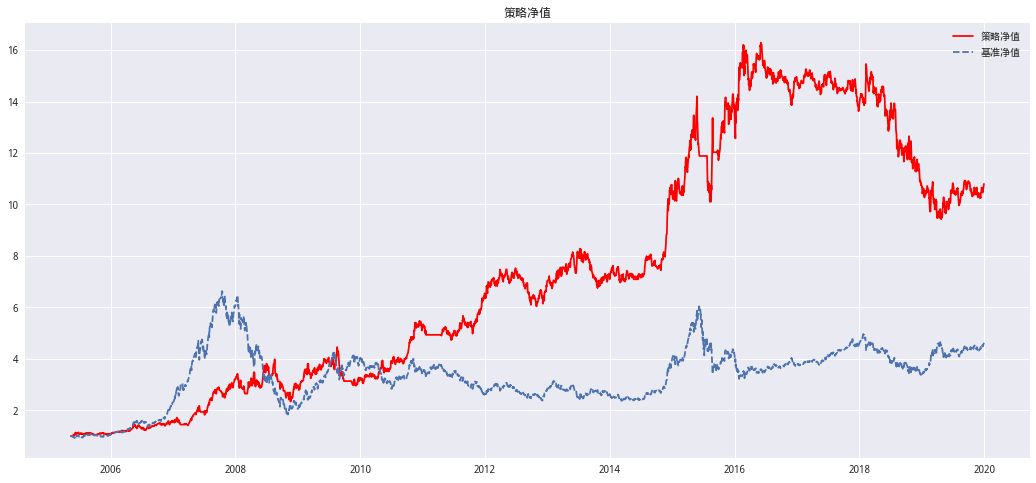

In [17]:
mpl.rcParams['font.family']='serif'
plt.figure(figsize=(18,8))
plt.title('策略净值')
plt.plot(nav,label='策略净值',c='r')
plt.plot((1+slice_ret).cumprod(),label='基准净值',ls='--')
plt.legend()

# 函数式

In [317]:
def getHighMoment(EarnRate,k,N = 20):
    
    HighMoment = (EarnRate**k).rolling(window = N).mean()
    # 将前序的20日也填充
    
    for i in range(1,N-1):
        HighMoment[i] = (EarnRate[:i+1]**k).mean()
        
    return(HighMoment.fillna(0))

def getEMA(moment,alpha):
    EMA =  pd.DataFrame.ewm(moment,alpha = alpha,adjust = False).mean()
    return(EMA)


def qiexian(profitrate,EMA):
    
    flag = np.zeros(len(profitrate))
    for i in range(1,len(profitrate)):
        if EMA[i - 1] > EMA[i-2]:
            flag[i] = 1
        else:
            flag[i] = -1 
    strategy_rate = profitrate * flag
    totalprofit = sum (strategy_rate)  

    return totalprofit


def BuySell(profitrate,Moment,EMA):
    # flag：每天持仓情况 1：多头，-1：空头，0：平仓
    flag = np.zeros(len(profitrate))
    cumrate = np.ones(len(profitrate))
    lossflag = 0   # 计算单次择时损失，超过10%平仓
    flagloss = 0  # 单次亏损超过10%时的信号方向
    # 计算最优alpha
    alpha_all = np.arange(0.05,0.51,0.05)

    for i in range(2,len(profitrate)):

        if i%90 ==0 :
            cumrate_all = [qiexian(list(profitrate[i - 90:i]),
                                   getEMA(Moment,alpha_all[j])[i - 90:i].values) for j in range(len(alpha_all))] 
            
            # 取使90天内累计收益率最大的alpha作为后续计算的alpha，并计算相应的EMA           
            alpha = alpha_all[np.argmax(cumrate_all)]
            EMA = getEMA(Moment,alpha)    
            
            
        if lossflag <  -0.1 :
            flag[i] = 0
            flagloss = flag[i-1]
            lossflag = 0
            continue

        
        if EMA[i - 1] - EMA[i-2] > 0 and flagloss != 1:
            flag[i] = 1
            flagloss = 0

        if EMA[i - 1] - EMA[i-2] < 0 and flagloss != -1:
            flag[i] = -1
            flagloss = 0

        if flag[i] == flag[i-1] :  
            lossflag = lossflag + profitrate[i]*flag[i]
            lossflag = min(lossflag,0)
        else:
            lossflag = 0


    strategy_rate = profitrate * flag 
    nav = (1+strategy_rate).cumprod()
    cumrate = nav - 1
    totalprofit = nav[len(nav)-1] - 1

    # 交易次数/择时次数
    num = 0
    for i in range(len(flag) - 1):
        if (flag[i+1]!= flag[i]) :
            num+=1
    Sharp = strategy_rate.mean()/strategy_rate.std()* 250**0.5
    MDD = max(1-nav/nav.cummax())
    return(cumrate,num,totalprofit,flag,Sharp,MDD)

In [318]:
# 计算
Moment_20_5 = getHighMoment(ret_df['ret'],5)
EMA_04 = getEMA(Moment_20_5,0.5)
cumrate,num,totalprofit,flag,Sharp,MDD = BuySell(ret_df['ret'],Moment_20_5,EMA_04)

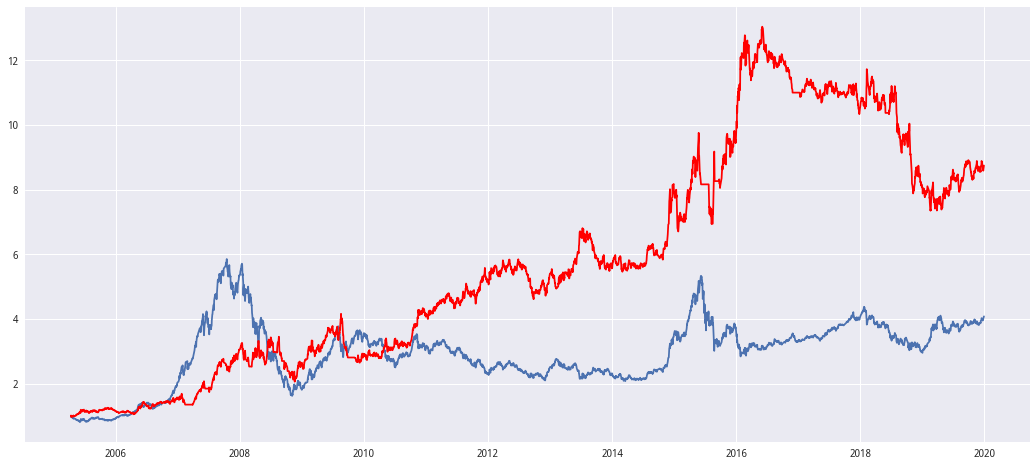

In [319]:
# 结果可视化
plt.figure(figsize=(18,8))
HS = plt.subplot(111)
#HS.plot(price_data['close'])
HS.plot((1+price_data['close'].pct_change()).cumprod())
#xticks = np.arange(0,price_data.shape[0],int(price_data.shape[0]/7))
#HS.set_xticks(xticks)
#HS.set_xticklabels(price_data.index,rotation=60)
#ax2 = HS.twinx()  
#ax2.plot(cumrate, 'r')
HS.plot(cumrate+1,c='r')

# 阈值对净值的影响

In [11]:
start_date = '2005-04-08'
end_date = '2019-12-31'  # 回测截止日


def backtesting(index_symbol: str,
                start_date: str,
                end_date: str,
                cal_momentt_window: int = 20,
                rolling_window: int = 90,
                order: int = 5,
                threshold: float = 0.1):

    # 获取数据
    price_data = get_price(
        index_symbol, start_date=start_date, end_date=end_date, fields='close')

    # 计算收益
    ret_df = price_data.pct_change()
    ret_df.rename(columns={'close': 'ret'}, inplace=True)

    # 计算5阶矩
    momentt = ret_df['ret'].rolling(cal_momentt_window).apply(
        cal_moment, kwargs={'Order': order}, raw=False)

    # 计算alpha取值范围
    alpha = np.arange(0.05, 0.55, step=0.05)

    # 计算不同参数的EMA
    ema_momentt = pd.concat(
        [momentt.ewm(alpha=x, adjust=False).mean() for x in alpha], axis=1)
    ema_momentt.columns = alpha

    # 之后一期T日信号为T-1日产生的
    diff_ema = ema_momentt.diff().shift(1)

    # 各个alpha计算出的ema累计90日收益
    ## 大于0多头，小于0空头
    ## 逻辑等价于EMA_{t-1} > EMA_{t-2} 多头,反之
    cond = ((diff_ema > 0) * 1 + (diff_ema < 0) * -1)

    cum90rate = cond * np.broadcast_to(
        np.expand_dims(ret_df['ret'].values, axis=1), diff_ema.shape)

    # 90日累计收益
    cum90rate = cum90rate.fillna(0).rolling(rolling_window).sum()

    # 去除前序20日的高阶矩日期
    slice_ret = ret_df['ret'].iloc[cal_momentt_window:]
    slice_momentt = momentt.iloc[cal_momentt_window:]
    slice_ema = ema_momentt.iloc[cal_momentt_window:]
    slice_diff_ema = diff_ema.iloc[cal_momentt_window:]
    slice_cum90rate = cum90rate.iloc[cal_momentt_window:]

    lossflag = 0  # 记录单次亏损阈值
    loss_position = 0  # 记录发生亏损的方向

    flag = np.zeros(len(slice_ret))  # 持仓 1多头,0空仓,-1空仓

    set_alpha = 0.4  # 初始ema的alpha值

    for i in range(1, len(slice_ret)):

        if i % 90 == 0:
            set_alpha = slice_cum90rate.iloc[i].idxmax()

        if lossflag < -threshold:
            flag[i] = 0  # 上一日发生亏损，本日空仓
            loss_position = flag[i - 1]  # 记录的持仓方向为上个发生亏损的方向
            lossflag = 0  # 记录的数据清0
            continue  # 之间执行下个循环

        # 多头信号 且 亏损方向不为多头
        if slice_diff_ema[set_alpha].iloc[i] > 0 and loss_position != 1:

            flag[i] = 1
            loss_position = 0

        # 空头信号 且 亏损方向不为空头
        if slice_diff_ema[set_alpha].iloc[i] < 0 and loss_position != -1:

            flag[i] = -1
            loss_position = 0

        if flag[i] == flag[i - 1]:

            lossflag = lossflag + flag[i] * slice_ret[i]
            lossflag = min(lossflag, 0)
        else:
            lossflag = 0

    strategy_rate = slice_ret * flag
    nav = (1 + strategy_rate).cumprod()
    
    return nav

# 计算策略年化收益率
def Annualized_Returns(series:pd.Series):
    
    return ((series.iloc[-1]/series.iloc[0])**(250/len(series))-1)*100

In [22]:
# 止损阈值
threshold = np.arange(0,0.11,0.02)
temp = {}
for i in threshold:
    temp[i] = backtesting('000300.XSHG',start_date,end_date,threshold=i)
    
df = pd.concat(temp,axis=1)

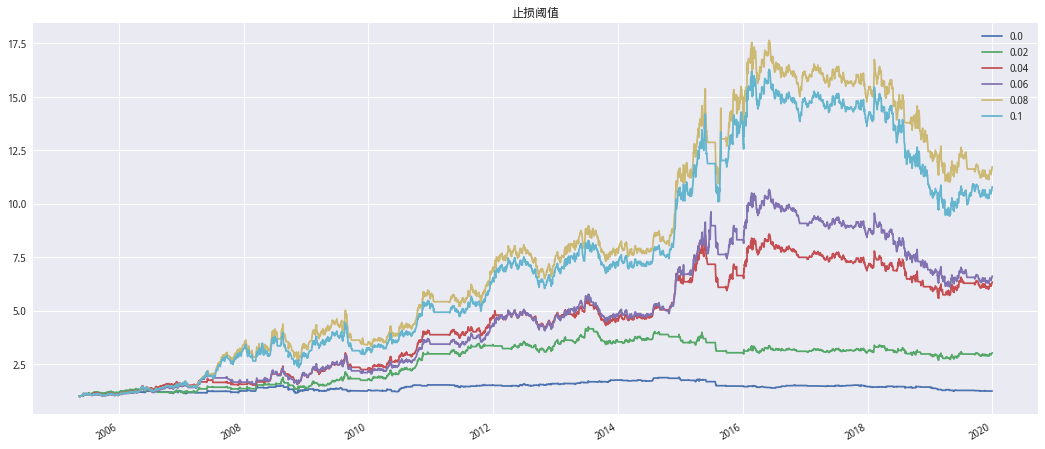

In [41]:
df.plot(figsize=(18,8),title='止损阈值')

In [24]:
# 各年度年化收益情况
group_return = df.groupby(pd.Grouper(freq='Y')).apply(Annualized_Returns)
group_return

,0.0,0.02,0.04,0.06,0.08,0.1
2005-12-31,18.246819,27.728938,14.251940,6.601378,10.638147,10.638147
2006-12-31,9.199072,-0.096222,42.281662,41.422124,44.269545,44.269545
2007-12-31,1.881850,12.758413,-0.987835,11.001406,120.739588,107.705756
2008-12-31,6.850274,5.218601,29.528232,23.021356,-0.152655,-7.148689
2009-12-31,1.227304,33.415941,20.742342,11.840971,8.624225,13.826428
2010-12-31,19.772017,68.486783,70.688377,61.270941,64.933015,64.933015
2011-12-31,0.516138,15.091004,24.180494,28.856513,21.694759,23.160425
2012-12-31,5.470227,6.215313,2.174099,9.914020,9.914020,9.914020
2013-12-31,11.312137,-0.429427,-6.373366,-0.483575,1.577922,0.829805
2014-12-31,2.308744,4.415481,44.675477,46.819142,49.156121,49.156121


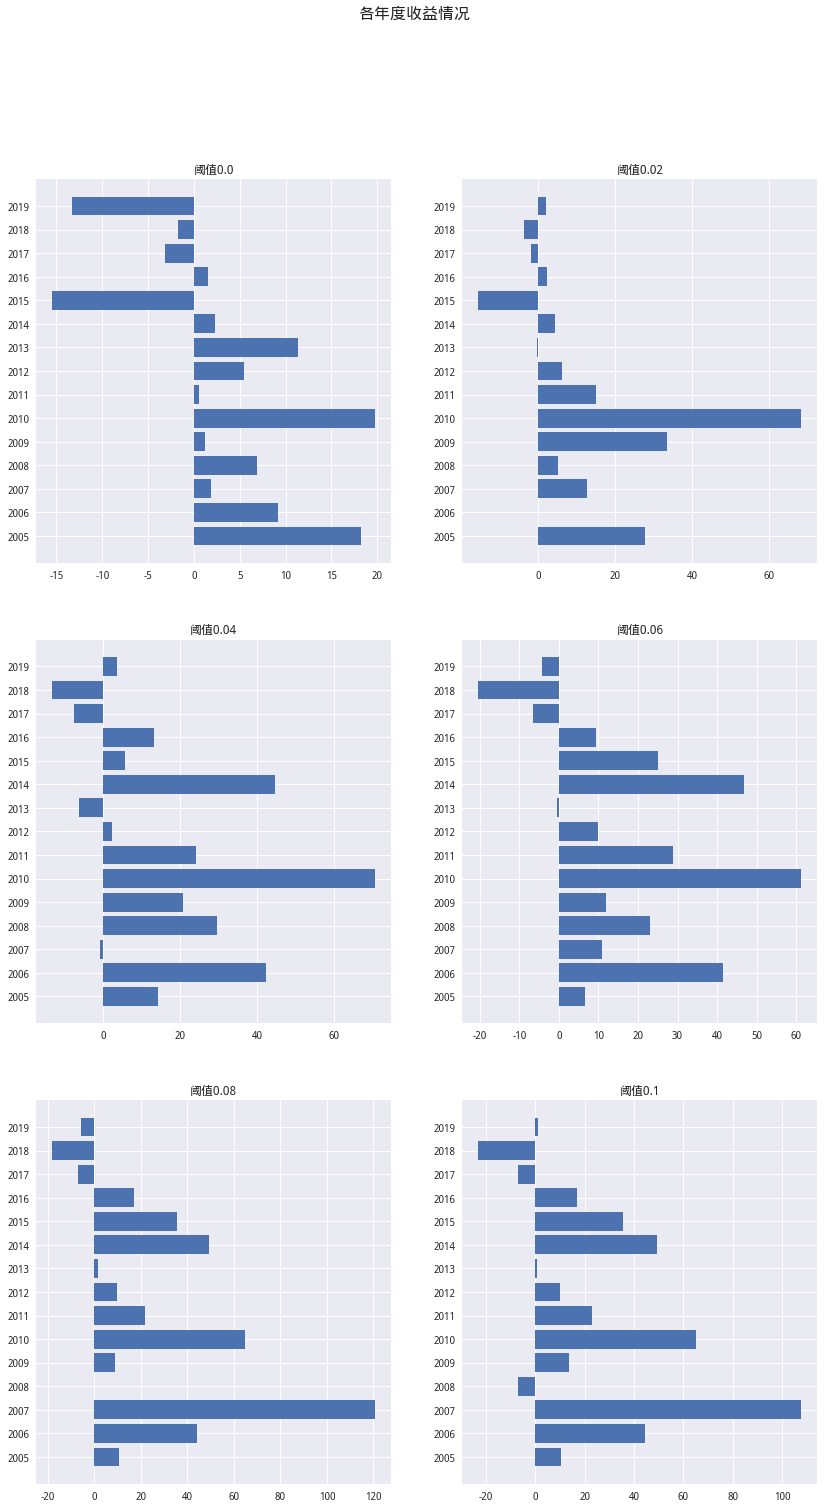

In [50]:
col = df.columns # 获取列数
fig = plt.figure(figsize=(14,4*len(col)))
fig.suptitle('各年度收益情况',fontsize=16)
y_ticks = group_return.index.strftime('%Y')
for i,n in enumerate(col):
    ax = fig.add_subplot(len(col)/2,2,i+1)
    ax.title.set_text('阈值'+str(n))
    ax = plt.barh(y_ticks,group_return[n])

# 不同奇数阶矩择时

In [51]:
# 止损阈值
order = [1,3,5,7]
temp = {}
for i in order:
    temp[i] = backtesting('000300.XSHG',start_date,end_date,threshold=0.1,order=i)
    
df = pd.concat(temp,axis=1)

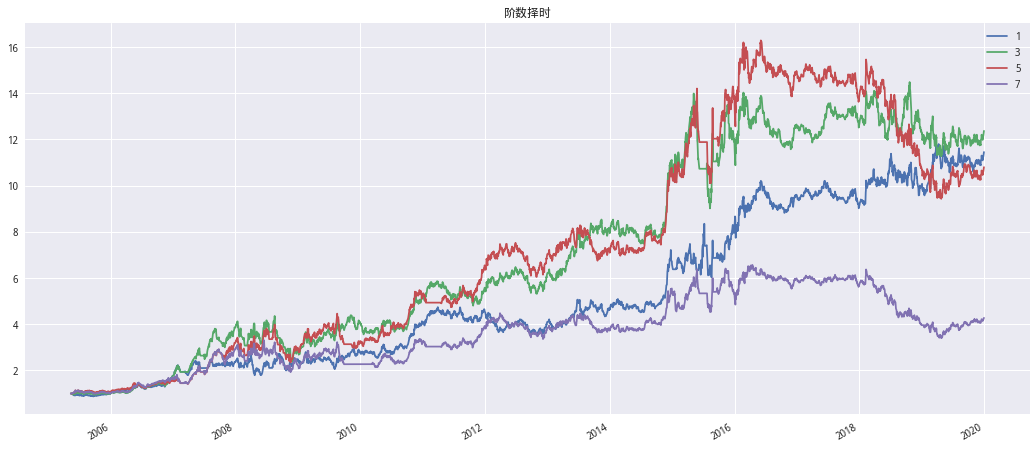

In [52]:
df.plot(figsize=(18,8),title='阶数择时')

In [53]:
# 各年度年化收益情况
group_return = df.groupby(pd.Grouper(freq='Y')).apply(Annualized_Returns)
group_return

,1,3,5,7
2005-12-31,-0.468203,-0.686012,10.638147,0.121836
2006-12-31,77.139910,76.711819,44.269545,63.475382
2007-12-31,32.822365,121.308569,107.705756,77.698493
2008-12-31,5.088437,-26.276584,-7.148689,-23.723862
2009-12-31,15.537365,48.270889,13.826428,5.268423
2010-12-31,48.840156,28.288797,64.933015,43.631811
2011-12-31,11.845898,7.248380,23.160425,20.043316
2012-12-31,-8.544982,14.022995,9.914020,-0.015212
2013-12-31,14.474180,29.262581,0.829805,-3.359001
2014-12-31,42.313008,37.282311,49.156121,46.259644


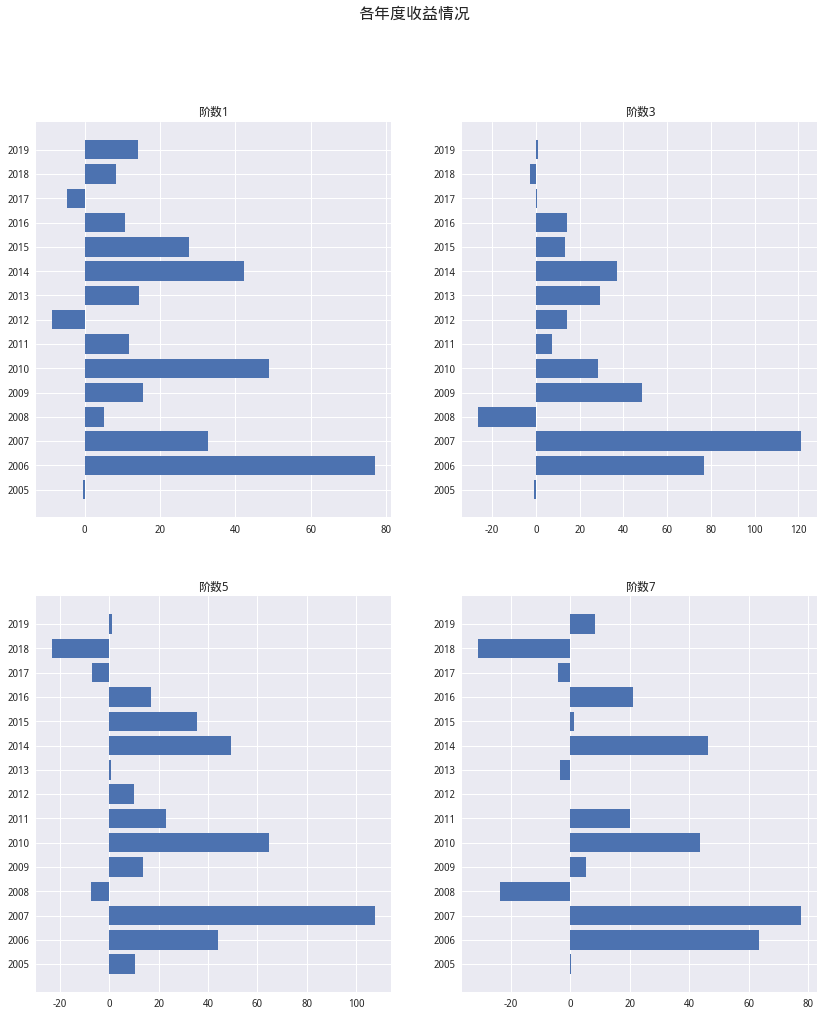

In [54]:
col = df.columns # 获取列数
fig = plt.figure(figsize=(14,4*len(col)))
fig.suptitle('各年度收益情况',fontsize=16)
y_ticks = group_return.index.strftime('%Y')
for i,n in enumerate(col):
    ax = fig.add_subplot(len(col)/2,2,i+1)
    ax.title.set_text('阶数'+str(n))
    ax = plt.barh(y_ticks,group_return[n])

# 运用到个股上

利用高阶矩择时在上证50成分股中择时(这里为了节约时间成分股以近期的成分股数据)
这里只做单多头

In [44]:
# 获取股票池
stock_pool = get_index_stocks('000016.XSHG')

# 数据获取
data = get_price(
    stock_pool,
    start_date='2010-01-01',
    end_date='2019-12-31',
    fields='close',
    panel=False).set_index(['time', 'code'])

# 计算收益率
data['ret'] = data.groupby(level='code')['close'].pct_change()

# 计算5阶矩
data['moment_5'] = data.groupby(level='code')['ret'].apply(
    lambda x: x.rolling(20).apply(cal_moment, kwargs={'Order': 5}, raw=True))

# 计算各alpha的ema
alpha_all = np.arange(0.05, 0.55, step=0.05)

ema_df = pd.DataFrame()

for i in alpha_all:

    ema_df[i] = data.groupby(level='code')['moment_5'].apply(
        lambda x: x.ewm(alpha=i, adjust=False).mean())

# 计算差值 T日信号为T-1产生的
diff_ema = ema_df.groupby(level='code').diff().shift(1)

# 计算累计收益
cond = (diff_ema > 0) * 1 + (diff_ema < 0) * -1

ret_shape = np.broadcast_to(
    np.expand_dims(data['ret'].values, axis=1), diff_ema.shape)

cumulative_sum = (ret_shape * cond).fillna(0)
rolling_cumrate = cumulative_sum.groupby(
    level='code').apply(lambda x: x.rolling(90).sum())

# 获取ema累计最大值的alpha
max_ema = rolling_cumrate.groupby(
    level='time', group_keys=False).apply(lambda x: x.idxmax(axis=1))

stack_diff_ema = diff_ema.stack()
stack_diff_ema.index.names = ['time','code','alpha']

# 交易日
trade_list = max_ema.index.levels[0][22:]
begin_date = min(trade_list)

# 初始alpha
code_index = diff_ema.loc[begin_date, 0.5].dropna().index.tolist()
alpha_index = [0.5] * len(code_index)

# 持仓标记 1为多头，0为空仓，-1为空头
flag = pd.DataFrame({'flag':np.zeros(len(diff_ema))},index = diff_ema.index)
flag['ret'] = data['ret']

# 记录亏损方向
loss_position = []


stock_index = pd.MultiIndex.from_arrays([[begin_date] * len(code_index),
                                      code_index])

# 止损
loss_value = pd.Series()
cut_date = []

for trade, alpha_series in max_ema.groupby(level='time'):

    if (trade in trade_list) and trade_list.get_loc(trade) > 1:

        if trade_list.get_loc(trade) % 90 == 0 and trade_list.get_loc(
                trade) > 1:

            alpha_series = alpha_series.dropna()
            code_index = alpha_series.index.get_level_values(1)
            alpha_index = alpha_series.values
        
        
        stock_index = pd.MultiIndex.from_arrays([[trade]*len(code_index), code_index])
        set_alpha = pd.MultiIndex.from_arrays(
            [[trade]*len(code_index), code_index, alpha_index])
        
        
        
        if isinstance(cut_date, list):

            cut_date = min(trade_list)
        else:
            cut_date = cut_date

        print('loss_position%s' % loss_position)
        
        # 如果有需要止损的
        if loss_position:

            stock_index = stock_index.difference(
                pd.MultiIndex.from_arrays([[trade] * len(loss_position),
                                           loss_position]))

        filter_diff_ema = stack_diff_ema.loc[set_alpha]
        # 多头
        long_position_a = filter_diff_ema[filter_diff_ema > 0].reset_index(
            level=2, drop=True).index

        # 亏损标记的方向
        print('stock_index:%s' % stock_index.levels[1])
        long_position = long_position_a.intersection(stock_index)

        flag.loc[long_position, 'flag'] = 1

        # 单只标的是否超过止损
        if loss_value.empty:
            loss_value = (flag['flag'] *
                          flag['ret']).sort_index().loc[cut_date:trade].groupby(
                              level='code').sum()


        print('计算止损的时间段%s:%s' % (cut_date, trade))
        # 明日需要止损的列表
        loss_position = loss_value[loss_value < -0.1].index.tolist()

        if loss_position:
            cut_date = trade

        #print('cut_date:%s'%cut_date)
        #pt = PrettyTable()
        #pt.field_names = ['tradeDate','亏损大于止损阈值']
        #for loss_symbol in loss_position:
        #    pt.add_row([cut_date]+[loss_symbol])
        #print(pt)

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601088.XSHG', '601111.XSHG', '601166.XSHG',
       '601186.XSHG', '601318.XSHG', '601328.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601766.XSHG', '601857.XSHG', '601888.XSHG', '601939.XSHG',
       '601988.XSHG', '601989.XSHG'],
      dtype='object')
计算止损的时间段2010-02-03 00:00:00:2010-02-05 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XS

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601088.XSHG', '601111.XSHG', '601166.XSHG',
       '601186.XSHG', '601318.XSHG', '601328.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601766.XSHG', '601857.XSHG', '601888.XSHG', '601939.XSHG',
       '601988.XSHG', '601989.XSHG'],
      dtype='object')
计算止损的时间段2010-02-03 00:00:00:2010-03-15 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XS

计算止损的时间段2010-02-03 00:00:00:2010-04-09 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601088.XSHG', '601111.XSHG', '601166.XSHG',
       '601186.XSHG', '601318.XSHG', '601328.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601766.XSHG', '601857.XSHG', '601888.XSHG', '601939.XSHG',
       '601988.XSHG', '601989.XSHG'],
      dtype='object')
计算止损的时间段2010-02-03 00:00:00:2010-04-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG',

计算止损的时间段2010-02-03 00:00:00:2010-05-06 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601088.XSHG', '601111.XSHG', '601166.XSHG',
       '601186.XSHG', '601318.XSHG', '601328.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601766.XSHG', '601857.XSHG', '601888.XSHG', '601939.XSHG',
       '601988.XSHG', '601989.XSHG'],
      dtype='object')
计算止损的时间段2010-02-03 00:00:00:2010-05-07 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG',

计算止损的时间段2010-02-03 00:00:00:2010-06-02 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601088.XSHG', '601111.XSHG', '601166.XSHG',
       '601186.XSHG', '601318.XSHG', '601328.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601766.XSHG', '601857.XSHG', '601888.XSHG', '601939.XSHG',
       '601988.XSHG', '601989.XSHG'],
      dtype='object')
计算止损的时间段2010-02-03 00:00:00:2010-06-03 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG',

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:105: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-07-08 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-07-21 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-08-03 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-08-16 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-08-30 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2010-09-09 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-09-10 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-10-14 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-11-05 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-11-18 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2010-12-02 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-12-03 00:00:00

计算止损的时间段2010-02-03 00:00:00:2010-12-16 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-12-17 00:00:00

计算止损的时间段2010-02-03 00:00:00:2010-12-29 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2010-12-30 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-01-21 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2011-02-10 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-02-11 00:00:00

计算止损的时间段2010-02-03 00:00:00:2011-03-04 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-03-07 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-03-29 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-04-19 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-05-03 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2011-05-18 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-05-19 00:00:00

计算止损的时间段2010-02-03 00:00:00:2011-06-14 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-06-15 00:00:00

计算止损的时间段2010-02-03 00:00:00:2011-07-07 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-07-08 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-08-01 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-08-15 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2011-08-29 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-08-30 00:00:00

计算止损的时间段2010-02-03 00:00:00:2011-09-09 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-09-13 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-09-26 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2011-10-14 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-10-17 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-10-28 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-11-18 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2011-11-30 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-12-01 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2011-12-27 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-01-11 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-02-01 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-02-14 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-02-28 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-03-13 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2012-03-27 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-03-28 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-04-13 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-05-07 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2012-05-17 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-05-18 00:00:00

计算止损的时间段2010-02-03 00:00:00:2012-05-30 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-05-31 00:00:00

计算止损的时间段2010-02-03 00:00:00:2012-06-14 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-06-15 00:00:00

计算止损的时间段2010-02-03 00:00:00:2012-06-28 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-06-29 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-07-16 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-07-30 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2012-08-13 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-08-14 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-08-28 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2012-09-10 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-09-11 00:00:00

计算止损的时间段2010-02-03 00:00:00:2012-09-24 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-09-25 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-10-15 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-10-30 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2012-11-13 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-11-14 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-11-28 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-12-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2012-12-26 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2013-01-14 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-01-15 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-01-28 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-02-18 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-03-04 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2013-03-18 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-03-19 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-04-02 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2013-04-17 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-04-18 00:00:00

计算止损的时间段2010-02-03 00:00:00:2013-05-06 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-05-07 00:00:00

计算止损的时间段2010-02-03 00:00:00:2013-05-23 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-05-24 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-06-20 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2013-07-15 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-07-16 00:00:00

计算止损的时间段2010-02-03 00:00:00:2013-07-26 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-07-29 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-08-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-08-26 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-09-09 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-09-24 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-10-15 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-10-30 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2013-11-13 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-11-14 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-11-27 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2013-12-11 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-12-12 00:00:00

计算止损的时间段2010-02-03 00:00:00:2013-12-25 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2013-12-26 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-01-10 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-01-23 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2014-02-11 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-02-12 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-02-25 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-03-11 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2014-03-25 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-03-26 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-04-09 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2014-04-22 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-04-23 00:00:00

计算止损的时间段2010-02-03 00:00:00:2014-05-07 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-05-08 00:00:00

计算止损的时间段2010-02-03 00:00:00:2014-05-22 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-05-23 00:00:00

计算止损的时间段2010-02-03 00:00:00:2014-06-06 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-06-09 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-06-24 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-07-08 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-07-23 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-08-06 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-08-20 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-09-03 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-09-17 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-10-10 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-10-24 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2014-11-07 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-11-10 00:00:00

计算止损的时间段2010-02-03 00:00:00:2014-11-21 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-11-24 00:00:00

计算止损的时间段2010-02-03 00:00:00:2014-12-04 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-12-05 00:00:00

计算止损的时间段2010-02-03 00:00:00:2014-12-18 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2014-12-19 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-01-06 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-01-19 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2015-01-29 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-01-30 00:00:00

计算止损的时间段2010-02-03 00:00:00:2015-03-04 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-03-05 00:00:00

计算止损的时间段2010-02-03 00:00:00:2015-03-18 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-03-19 00:00:00

计算止损的时间段2010-02-03 00:00:00:2015-03-31 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-04-01 00:00:00

计算止损的时间段2010-02-03 00:00:00:2015-04-15 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-04-16 00:00:00

计算止损的时间段2010-02-03 00:00:00:2015-04-28 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-04-29 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-05-15 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2015-05-29 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-06-01 00:00:00

计算止损的时间段2010-02-03 00:00:00:2015-06-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-06-15 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-06-30 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2015-07-14 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-07-15 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-07-28 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-08-10 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-08-21 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-09-17 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2015-10-16 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-10-19 00:00:00

计算止损的时间段2010-02-03 00:00:00:2015-10-30 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-11-02 00:00:00

计算止损的时间段2010-02-03 00:00:00:2015-11-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-11-13 00:00:00

计算止损的时间段2010-02-03 00:00:00:2015-12-07 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-12-08 00:00:00

计算止损的时间段2010-02-03 00:00:00:2015-12-21 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2015-12-22 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-01-06 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-01-22 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2016-02-04 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-02-05 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-02-26 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2016-03-11 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-03-14 00:00:00

计算止损的时间段2010-02-03 00:00:00:2016-03-25 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-03-28 00:00:00

计算止损的时间段2010-02-03 00:00:00:2016-04-08 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-04-11 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-05-09 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-05-24 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2016-06-03 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-06-06 00:00:00

计算止损的时间段2010-02-03 00:00:00:2016-07-04 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-07-05 00:00:00

计算止损的时间段2010-02-03 00:00:00:2016-07-19 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-07-20 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-08-02 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-08-17 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2016-08-31 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-09-01 00:00:00

计算止损的时间段2010-02-03 00:00:00:2016-09-19 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-09-20 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-10-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2016-10-26 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-10-27 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-11-10 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2016-11-24 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-11-25 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-12-08 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2016-12-22 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2017-01-06 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-01-09 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-02-10 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2017-02-23 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-02-24 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-03-09 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-03-24 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-04-11 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-04-25 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-05-10 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2017-05-24 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-05-25 00:00:00

计算止损的时间段2010-02-03 00:00:00:2017-06-09 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-06-12 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-06-26 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-07-11 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-07-26 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2017-08-09 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-08-10 00:00:00

计算止损的时间段2010-02-03 00:00:00:2017-08-25 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-08-28 00:00:00

计算止损的时间段2010-02-03 00:00:00:2017-09-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-09-13 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-09-26 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2017-10-17 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-10-18 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-11-01 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-11-15 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-11-29 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-12-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2017-12-27 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2018-01-11 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-01-12 00:00:00

计算止损的时间段2010-02-03 00:00:00:2018-01-25 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-01-26 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-02-08 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2018-03-02 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-03-05 00:00:00

计算止损的时间段2010-02-03 00:00:00:2018-03-19 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-03-20 00:00:00

计算止损的时间段2010-02-03 00:00:00:2018-04-02 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-04-03 00:00:00

计算止损的时间段2010-02-03 00:00:00:2018-04-18 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-04-19 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-05-16 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-05-31 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-06-13 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-06-28 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2018-07-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-07-13 00:00:00

计算止损的时间段2010-02-03 00:00:00:2018-07-26 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-07-27 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-08-09 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-08-23 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2018-09-06 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-09-07 00:00:00

计算止损的时间段2010-02-03 00:00:00:2018-10-08 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-10-09 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-10-29 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-11-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2018-11-22 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-11-23 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-12-06 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2018-12-19 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-01-03 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2019-01-23 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-01-24 00:00:00

计算止损的时间段2010-02-03 00:00:00:2019-02-21 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-02-22 00:00:00

计算止损的时间段2010-02-03 00:00:00:2019-03-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-03-13 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-04-04 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-04-18 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-05-16 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2019-05-28 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-05-29 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-06-12 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2019-07-03 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-07-04 00:00:00

计算止损的时间段2010-02-03 00:00:00:2019-07-25 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-07-26 00:00:00

计算止损的时间段2010-02-03 00:00:00:2019-08-19 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-08-20 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-09-03 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

计算止损的时间段2010-02-03 00:00:00:2019-09-16 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-09-17 00:00:00

计算止损的时间段2010-02-03 00:00:00:2019-09-27 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-09-30 00:00:00

stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-10-29 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG'

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-11-22 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

计算止损的时间段2010-02-03 00:00:00:2019-12-06 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-12-09 00:00:00

loss_position[]
stock_index:Index(['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG',
       '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG',
       '600050.XSHG', '600104.XSHG', '600196.XSHG', '600276.XSHG',
       '600309.XSHG', '600340.XSHG', '600519.XSHG', '600547.XSHG',
       '600585.XSHG', '600690.XSHG', '600703.XSHG', '600837.XSHG',
       '600887.XSHG', '601012.XSHG', '601066.XSHG', '601088.XSHG',
       '601111.XSHG', '601138.XSHG', '601166.XSHG', '601186.XSHG',
       '601211.XSHG', '601236.XSHG', '601288.XSHG', '601318.XSHG',
       '601319.XSHG', '601328.XSHG', '601336.XSHG', '601390.XSHG',
       '601398.XSHG', '601601.XSHG', '601628.XSHG', '601668.XSHG',
       '601688.XSHG', '601766.XSHG', '601818.XSHG', '601857.XSHG',
       '601888.XSHG', '601939.XSHG', '601988.XSHG', '601989.XSHG',
       '603259.XSHG', '603993.XSHG'],
      dtype='object', name='code')
计算止损的时间段2010-02-03 00:00:00:2019-12-23 00:00:00
loss_position[]
stock_index:Index(['600000.XSHG

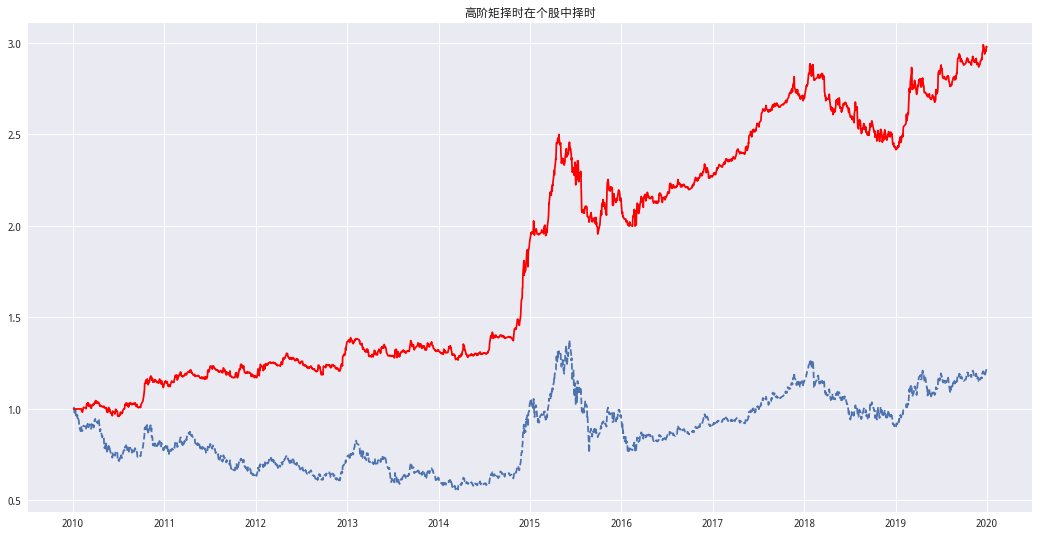

In [45]:
# 基准
benchmark = get_price(
                '000016.XSHG',
                start_date='2010-01-01',
                end_date='2019-12-31',
                fields='close',
                panel=False).pct_change()

benchmark = (1+benchmark).cumprod()
# 策略
ret = (flag['flag']*flag['ret']).groupby(level='time').mean()

plt.figure(figsize=(18,9))
plt.title('高阶矩择时在个股中择时')
plt.plot(benchmark,ls='--',label='基准')
plt.plot((1+ret).cumprod(),c='r',label='净值')
